In [14]:
# from google.colab import drive
# drive.mount('/content/drive')

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay

pd.set_option('display.max_columns', None)

In [16]:
# read in training file 
training_data = pd.read_csv('../Data/hip_fracture_training.csv')
# training_data = pd.read_csv('hip_fracture_training.csv')


In [17]:
def filter_data(df, preop_cols): 

    # filters for only the preoperative columns
    df_preop = df[preop_cols]

    return df_preop    

In [18]:
peri_cols = [
    'TransferStatus_17', 'TransferStatus_18', 'TransferStatus_19', 'TransferStatus_20',
    'DispoLocationPost_21', 'DispoLocationPost_22', 'DispoLocationPost_23', 'DispoLocationPost_24',
    'DispoLocationPost_25', 'DispoLocationPost_26', 'DispoLocationPost_27', 'DispoLocationPost_28',
    'DispoLocationPost_29', 'DispoLocationPost_30', 'DispoLocationPost_31', 'DispoLocationPost_32',
    'MEDMGMT_13', 'MEDMGMT_14', 'MEDMGMT_15', 'StandardHip_17', 'HipFractureType_44',
    'HipFractureType_45', 'HipFractureType_46', 'HipFractureType_47', 'HipFractureType_48',
    'PathologicHipFractures_49', 'PathologicHipFractures_50', 'PathologicHipFractures_51',
    'DischargeNotHome', 'READMISSION30D', 
    'CPT', 'WORKRVU', 'INOUT', 'OPERYR', 'ANESTHES', 'EMERGNCY', 'ADMQTR', 'OPTIME', 'TOTHLOS', 'HTOODAY', 
]
peri_df = filter_data(training_data, peri_cols)

print(peri_df.shape)

print(peri_df.TransferStatus_20.dtype)

(29188, 40)
int64


In [19]:
#next we need to scale the numerical values 
num_cols = ['OPTIME', 'TOTHLOS', 'HTOODAY']

def scale_num(df, num_cols):
    # create a DataFrame with only the num columns
    num_df = df[num_cols]

    # replace missing values (-99) with NaN
    num_df = num_df.replace(-99, np.nan)

    # impute missing values with the median
    imputer = SimpleImputer(strategy='median')
    
    #transform num values 
    num_df = imputer.fit_transform(num_df)

    # create a StandardScaler object
    scaler = StandardScaler()

    # fit the scaler to the num data
    scaler.fit(num_df)

    # transform the num data
    scaled_data = scaler.transform(num_df)

    # create a new DataFrame with the scaled num data
    scaled_num_df = pd.DataFrame(scaled_data, columns=num_cols)

    # create a new DataFrame that contains both the scaled lab columns and the other columns from the input DataFrame
    new_df = pd.concat([df.drop(num_cols, axis=1), scaled_num_df], axis=1)

    return new_df


scaled_df  = scale_num(peri_df, num_cols)

In [20]:
# Drop rows where ANESTHES==Unknown
scaled_df_1 = scaled_df[scaled_df['ANESTHES'].str.contains('Unknown')==False]

In [21]:
#convert EMERGENCY and INOUT
def convert_binary(df): 
    encoding_EMERGENCY = {'No': 0, 'Yes': 1}
    encoding_INOUT = {'Inpatient': 1, 'Outpatient': 0}
    encoding_CPT = {'27236': 0, '27244': 1, '27245': 2}
    encoding_WORKRVU = {'17.61': 0, '18.18': 1}
    encoding_ANESTHES = {
        'Epidural':0, 'General': 1, 'Local': 2, 'MAC/IV Sedation': 3,
        'None': 4, 'Other': 5, 'Regional': 6, 'Spinal': 7
    }
    # encoding_ADMQTR = {}
    encoding_OPERYR = {'2016': 0, '2017': 1, '2018': 2, '2019': 3, '2020': 4}
    
    df['EMERGNCY'] = df['EMERGNCY'].map(encoding_EMERGENCY)
    df['INOUT'] = df['INOUT'].map(encoding_INOUT)
    df['CPT'] = df['CPT'].map(encoding_CPT)
    df['WORKRVU'] = df['WORKRVU'].map(encoding_WORKRVU)
    df['ANESTHES'] = df['ANESTHES'].map(encoding_ANESTHES)
    # df['ADMQTR'] = df['ADMQTR'].map(encoding_ADMQTR)
    df['OPERYR'] = df['OPERYR'].map(encoding_OPERYR)
    
    df_encoded = df 
    return df_encoded

peri_df_1 = convert_binary(scaled_df_1)

/var/folders/v_/hw4xv95j5yv675n9vh8qb21h0000gn/T/ipykernel_38436/3117266365.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EMERGNCY'] = df['EMERGNCY'].map(encoding_EMERGENCY)
/var/folders/v_/hw4xv95j5yv675n9vh8qb21h0000gn/T/ipykernel_38436/3117266365.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['INOUT'] = df['INOUT'].map(encoding_INOUT)
/var/folders/v_/hw4xv95j5yv675n9vh8qb21h0000gn/T/ipykernel_38436/3117266365.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [22]:
# next we need to remove unknowns
unknwon_cols = ['TransferStatus_20', 'DispoLocationPost_31']

cleaned_df = peri_df_1[(peri_df_1['TransferStatus_20'] != 1) & (peri_df_1['DispoLocationPost_31'] != 1)]

# remove columns with only one unique value (does not add info)
for col in cleaned_df.columns:
    if len(cleaned_df[col].unique()) == 1:
        cleaned_df.drop(col,inplace=True,axis=1)

print(cleaned_df.shape)

(29149, 34)


/var/folders/v_/hw4xv95j5yv675n9vh8qb21h0000gn/T/ipykernel_38436/2943285225.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.drop(col,inplace=True,axis=1)
/var/folders/v_/hw4xv95j5yv675n9vh8qb21h0000gn/T/ipykernel_38436/2943285225.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.drop(col,inplace=True,axis=1)
/var/folders/v_/hw4xv95j5yv675n9vh8qb21h0000gn/T/ipykernel_38436/2943285225.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

In [23]:
def split_data(df): 
    X = df.drop(labels = ['READMISSION30D'], axis = 1) 
    y = pd.DataFrame(df['READMISSION30D']) 
    X_train,X_test,y_train,y_test = train_test_split(X, y, stratify = y, test_size= .2, random_state= 0 )
    return X_train,X_test,y_train,y_test

X_train,X_test,y_train,y_test = split_data(cleaned_df)
display(X_train.info()) 
display(X_test.info())
display(y_train.info())
display(y_test.info())


<class 'pandas.core.frame.DataFrame'>
Index: 23319 entries, 24861 to 1081
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   TransferStatus_17          23319 non-null  int64  
 1   TransferStatus_18          23319 non-null  int64  
 2   TransferStatus_19          23319 non-null  int64  
 3   DispoLocationPost_21       23319 non-null  int64  
 4   DispoLocationPost_22       23319 non-null  int64  
 5   DispoLocationPost_23       23319 non-null  int64  
 6   DispoLocationPost_24       23319 non-null  int64  
 7   DispoLocationPost_25       23319 non-null  int64  
 8   DispoLocationPost_26       23319 non-null  int64  
 9   DispoLocationPost_28       23319 non-null  int64  
 10  DispoLocationPost_29       23319 non-null  int64  
 11  DispoLocationPost_30       23319 non-null  int64  
 12  DispoLocationPost_32       23319 non-null  int64  
 13  MEDMGMT_13                 23319 non-null  int64

None

<class 'pandas.core.frame.DataFrame'>
Index: 5830 entries, 16646 to 6683
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   TransferStatus_17          5830 non-null   int64  
 1   TransferStatus_18          5830 non-null   int64  
 2   TransferStatus_19          5830 non-null   int64  
 3   DispoLocationPost_21       5830 non-null   int64  
 4   DispoLocationPost_22       5830 non-null   int64  
 5   DispoLocationPost_23       5830 non-null   int64  
 6   DispoLocationPost_24       5830 non-null   int64  
 7   DispoLocationPost_25       5830 non-null   int64  
 8   DispoLocationPost_26       5830 non-null   int64  
 9   DispoLocationPost_28       5830 non-null   int64  
 10  DispoLocationPost_29       5830 non-null   int64  
 11  DispoLocationPost_30       5830 non-null   int64  
 12  DispoLocationPost_32       5830 non-null   int64  
 13  MEDMGMT_13                 5830 non-null   int64 

None

<class 'pandas.core.frame.DataFrame'>
Index: 23319 entries, 24861 to 1081
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   READMISSION30D  23319 non-null  int64
dtypes: int64(1)
memory usage: 364.4 KB


None

<class 'pandas.core.frame.DataFrame'>
Index: 5830 entries, 16646 to 6683
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   READMISSION30D  5830 non-null   int64
dtypes: int64(1)
memory usage: 91.1 KB


None

In [24]:
def rf_feature_importance(X_train,X_test,y_train): 

    #we will start off using the default scikit learn features 
    rf_model = RandomForestClassifier(criterion='gini',max_depth=None, min_samples_leaf=5,n_estimators=1000,
                                 max_features=0.1,max_samples=0.7,random_state=0)
     #Fit the tree to the data
    rf_model.fit(X_train, y_train)

    #predict on the validation set
    preds = rf_model.predict(X_test)

    #define feature names 
    feat_names = X_train.columns 

    #define the number of features to show
    num_to_show = 55 

    # Determine the relative importance of each feature using the random forest model
    importances = rf_model.feature_importances_

    # Get an array of the indices that would sort "importances" in reverse order to get largest to smallest
    indices = np.argsort(importances)[::-1]
    ranked_feats = []
    for i in range(len(indices)):
        feat_name = feat_names[indices[i]]
        ranked_feats.append(feat_name)
    RF_ranking = pd.DataFrame()
    RF_ranking['Feat Index'] = indices
    RF_ranking['Feature'] = ranked_feats
    RF_ranking['Importance'] = np.sort(importances)[::-1]
    display(RF_ranking.iloc[:num_to_show,:])

    # Plot the importance value for each feature
    RF_ranking[:30][::-1].plot(x='Feature',y='Importance',kind='barh',figsize=(12,7),legend=False,title='RF Feature Importance')
    plt.show()

    return RF_ranking, rf_model, preds

/var/folders/v_/hw4xv95j5yv675n9vh8qb21h0000gn/T/ipykernel_38436/2598169905.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


,Feat Index,Feature,Importance
0,30,OPTIME,0.307746
1,31,TOTHLOS,0.164665
2,32,HTOODAY,0.089584
3,29,ADMQTR,0.087893
4,27,ANESTHES,0.043137
5,16,StandardHip_17,0.034410
6,28,EMERGNCY,0.027456
7,19,HipFractureType_46,0.020703
8,11,DispoLocationPost_30,0.019984
9,18,HipFractureType_45,0.019260


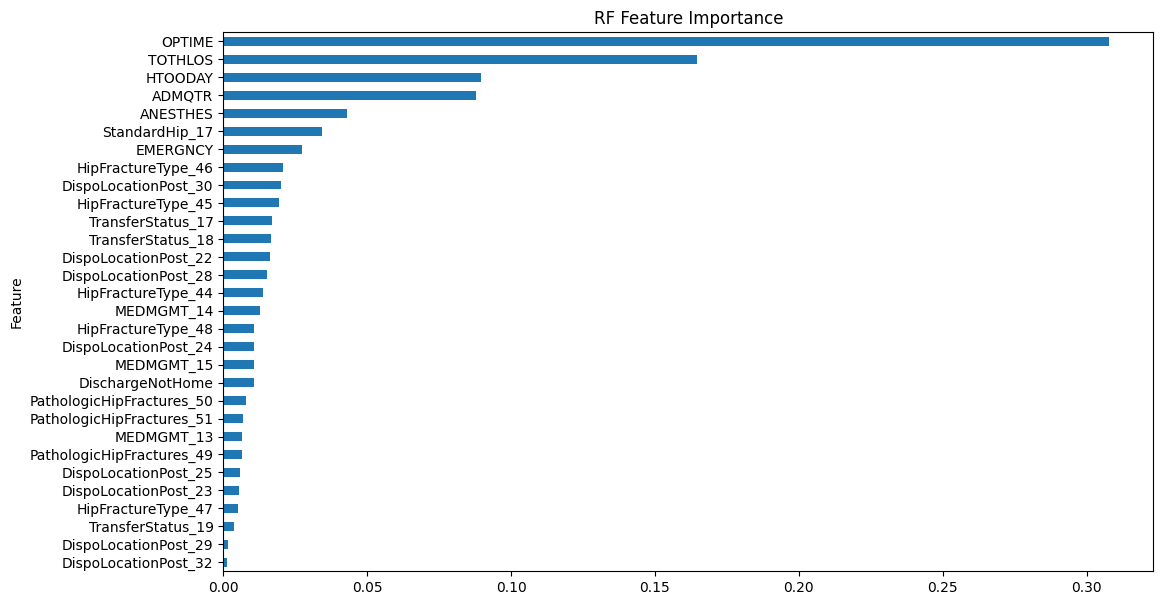

In [25]:
RF_ranking, rf_model, preds = rf_feature_importance(X_train,X_test,y_train)


/Users/zhixiangyao/Desktop/Spring 2023/Intro BioMed Data Sci/Project/BME580project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zhixiangyao/Desktop/Spring 2023/Intro BioMed Data Sci/Project/BME580project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zhixiangyao/Desktop/Spring 2023/Intro BioMed Data Sci/Project/BME580project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 

the results for RandomForestClassifier(max_features=0.1, max_samples=0.7, min_samples_leaf=5,
                       n_estimators=1000, random_state=0)              precision    recall  f1-score   support

           0       0.90      1.00      0.95      5270
           1       0.00      0.00      0.00       560

    accuracy                           0.90      5830
   macro avg       0.45      0.50      0.47      5830
weighted avg       0.82      0.90      0.86      5830



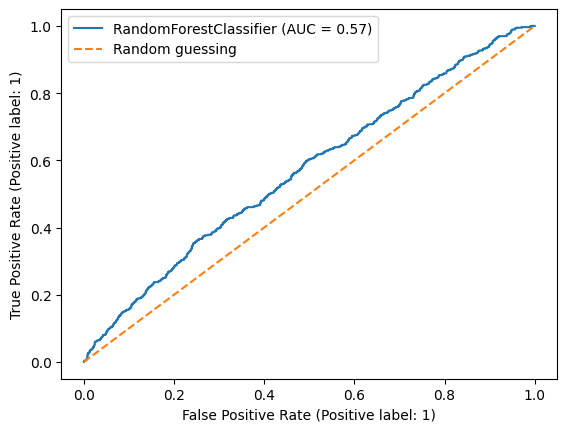

In [26]:
print(f'the results for {rf_model}' + classification_report(y_test, preds))
RocCurveDisplay.from_estimator(rf_model,X_test,y_test)
# Add a line to show the curve for random guessing
plt.plot([0,1],[0,1],linestyle='--',label='Random guessing')
plt.legend()
plt.show()